In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import time as tm
import Sprayer_PDE as SP

import pypolo2

# Environment -- PINNS

In [2]:
Setting = pypolo2.utilities.Config()

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model
Setting.env = env_model.solve(Setting.delta_t)


100%|██████████| 2.0/2.0 [00:00<00:00,  2.93it/s]    


In [3]:
# 确定存放地址
starttime = Setting.starttime.replace(' ', '-').replace(':', '-')
Savedir = './outputs/{}/releaserate_{}'.format(Setting.strategy_name,"%03d" %(Setting.delta_t*100))
Savename = 'seed{}'.format(Setting.seed)
Setting.save_dir = Savedir
Setting.save_name = Savename
evaluator = pypolo2.experiments.Evaluator()
logger = pypolo2.experiments.Logger(None, Setting)

# Sensor

In [4]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [5]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


# Set initual data

In [6]:
# 初始化污染源
# if Setting.randomsource == True:
#     # gengerate two set of random numbers for source locations
#     numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
#     pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
#     for i in range(Setting.sourcenum):
#         number = rng.randint(150, 300, size=1)
#         Setting.RR[i,0] = int(pairs[i,0])
#         Setting.RR[i,1] = int(pairs[i,1])
#         Setting.RR[i,2] = number

# print(Setting.RR)
# #  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
# s = 1
# Setting.R =  -6 * np.ones((Setting.grid_x, Setting.grid_y)) + 13 * np.random.random((Setting.grid_x, Setting.grid_y))
# for i in range(Setting.sourcenum):
#         Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
        
Setting.R[3][3] = 150
Setting.R[17][17] = 150
Setting.R[3][17] = 150
Setting.R[17][3] = 150

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model

y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))
time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))

#固定站的观测的观测
for time in range(Setting.time_before_sche):
    # y_stations[Setting.station_size*time:Setting.station_size*(time+1)] = sensor.sense(states=Setting.x_station, rng=rng).reshape(-1, 1)
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*Setting.time_co
    time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*1
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-10+1)*Setting.time_co
    Setting.env = env_model.solve((time+1)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    if time == 0:
        y_stations[:] = y_init[time] - 20
    # time_init[time] = (time+1)*Setting.time_co
    time_init[time] = (time+1)*1
    Setting.env = env_model.solve((1+Setting.time_before_sche+time)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = Setting.x_station
for i in range(Setting.time_before_sche-1):
    Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

100%|██████████| 2.0/2.0 [00:00<00:00,  4.59it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00, 14.58it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00, 15.34it/s]    
100%|██████████| 8.0/8.0 [00:00<00:00, 16.40it/s]    
100%|██████████| 10.0/10.0 [00:00<00:00, 16.41it/s]   
100%|██████████| 12.0/12.0 [00:00<00:00, 15.73it/s]   


# Model

In [7]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)

In [8]:
kernel = pypolo2.kernels.RBF(Setting)

In [9]:
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [10]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 05 loss:  8.64: 100%|██████████| 6/6 [00:00<00:00, 110.41it/s]


# Robot

In [11]:
vehicle_team = dict()
for i in range(Setting.team_size):
    robot = pypolo2.robots.SPRINKLER_REPLENISHANYWHERE(
        init_state = np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1]]),
        Setting = Setting
    )
    vehicle_team[i+1] = robot #因此team的id从1开始

# Strategy

In [12]:
strategy = pypolo2.strategies.SALatticePlanningMISprinklerControl_mimethod2(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )
Setting.strategy = strategy

# Experiment

In [13]:
#定义需要随时间更新的训练过程
def run(rng, model, Setting, sensor, evaluator, logger, vehicle_team) -> None:
    current_step = 0 #总规划长度
    adaptive_step = Setting.adaptive_step #自适应长度
    # change_step = Setting.R_change_interval - 0*Setting.adaptive_step # 污染源变化间隔
    change_step = 0
    spray_effect = 0 # 洒水效果
    result, MI_information, observed_env, computed_effect = None, None, None, None
    while current_step < Setting.max_num_samples:
        # 计算用于显示的信息量，目标估计，洒水效果
        allpoint_list = []
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                allpoint_list.append([i, j, model.time_stamp])
        allpoint = np.array(allpoint_list)
        mean, _ = model(allpoint)
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, mean, Setting.task_extent).ravel()
        prior_diag_std, poste_diag_std, _, _ = model.prior_poste(allpoint)
        hprior = pypolo2.objectives.entropy.gaussian_entropy(prior_diag_std.ravel())
        hposterior = pypolo2.objectives.entropy.gaussian_entropy(poste_diag_std.ravel())
        mi_all = hprior - hposterior
        if np.any(mi_all < 0.0):
            print(mi_all.ravel())
            raise ValueError("Predictive MI < 0.0!")
        MI_information = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        observed_env = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        computed_effect = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                MI_information[i,j] = mi_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                observed_env[i,j] = mean[i*(Setting.task_extent[3]-Setting.task_extent[2])+j,0]
                computed_effect[i,j] = sprayeffect_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                
        Setting.current_step = current_step
        # scheduling and update agent goals 计算搜索时间
        if adaptive_step >= Setting.adaptive_step:
            start = tm.time()
            result = Setting.strategy.get(model = model, Setting = Setting, pred = observed_env)
            adaptive_step = 0
            for id, vehicle in vehicle_team.items():
                vehicle.set_goals(result[id][0],result[id][1])
            end = tm.time()
            print('search_time')
            print(end-start)    
            
        # calculate metrix and save 
        coverage, mean_airpollution, max_airpollution = evaluator.eval_results(Setting.env, Setting.task_extent, vehicle_team)
        logger.append(current_step, Setting.env, observed_env, MI_information, computed_effect, vehicle_team, coverage, mean_airpollution, max_airpollution, spray_effect)
           
        # change source,每经过R_change_interval后，改变源分布和强度，
        # if change_step >= Setting.R_change_interval:
        #     change_step = 0
        #     if Setting.randomsource == True:
        #         # gengerate two set of random numbers for source locations
        #         numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
        #         pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
        #         for i in range(Setting.sourcenum):
        #             number = rng.randint(150, 300, size=1)
        #             Setting.RR[i,0] = int(pairs[i,0])
        #             Setting.RR[i,1] = int(pairs[i,1])
        #             Setting.RR[i,2] = number

        # print(Setting.RR)
        #  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
        # s = 1
        # # if change_step == 0:
        # #     s = 0.2
        # if change_step == 0 or change_step == Setting.R_change_interval - 1:
        #     s = 0.5
        # Setting.R =  -6 * np.ones((Setting.grid_x, Setting.grid_y)) + 13 * np.random.random((Setting.grid_x, Setting.grid_y))
        # for i in range(Setting.sourcenum):
        #      Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
             
        #测试画图，源固定且不动
        Setting.R[3][3] = 250
        Setting.R[17][17] = 250
        Setting.R[3][17] = 250
        Setting.R[17][3] = 250
             
        # 计算如果没有更新洒水时的环境变化
        env_model1 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = Setting.current_step * Setting.delta_t) # build model
        env_withoutspray = env_model1.solve(Setting.delta_t)
        # update state 并将车辆的轨迹和洒水轨迹取出来
        x_new = []
        y_new = []
        for id, vehicle in vehicle_team.items():
            vehicle.update()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            if Setting.current_step == 0:
                Setting.data_sprayer_train.append(pd.DataFrame())
            else:
                if vehicle.spray_flag == True:
                    new_pd = pd.DataFrame({"time":(Setting.current_step + 1) * Setting.delta_t, "x":current_state[0,0],\
                                            "y":current_state[0,1], "spray_volume":500},index=[0])
                    # Setting.data_sprayer_train[id-1] = Setting.data_sprayer_train[id-1].append(new_pd, ignore_index=True)
                    Setting.data_sprayer_train[id-1] = pd.concat([Setting.data_sprayer_train[id-1],new_pd])
        # 计算带入洒水后的环境情况
        env_model2 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = Setting.current_step * Setting.delta_t) # build model
        Setting.env = env_model2.solve(Setting.delta_t)
        sensor.set_env(Setting.env)
        # 计算洒水效果
        spray_effect = np.sum(env_withoutspray - Setting.env)
            
        # using new data to update gpr model
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)
        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        
        adaptive_step = adaptive_step + 1    
        current_step = current_step + 1
        change_step = change_step + 1  
    return 0

In [14]:
start = tm.time()
Setting.strategy = strategy
run(rng, model, Setting, sensor, evaluator, logger, vehicle_team)
# pypolo2.experiments.utilities.print_metrics(logger, Setting.max_num_samples-1)
end = tm.time()
# logger.save(end-start)  # I temporarily removed "makefile()".

current_turn
1.0
sche_step
18
mi_high
8.045053165393705
sprayeffectarv
[0.08154816 0.08156486 0.07694875 0.08009293 0.07868337]
CurrentInfo
0.8110791820349732
object_mi
[12.06757975 12.06757975 12.06757975 12.06757975 12.06757975]
enough_info
[False False False False False]
single_playout
176.0
search_time
158.82287788391113


100%|██████████| 2.0/2.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.16it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.61it/s]    


current_turn
2.0
sche_step
18
mi_high
14.091257288024101
sprayeffectarv
[0.11960682 0.09047544 0.08637884 0.10769122 0.1203758 ]
CurrentInfo
3.794787034555493
object_mi
[21.13688593 21.13688593 21.13688593 21.13688593 21.13688593]
enough_info
[False False False False False]
single_playout
115.0
search_time
110.08237767219543


100%|██████████| 2.0/2.0 [00:00<00:00,  3.82it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  5.30it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.31it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.75it/s]    


current_turn
3.0
sche_step
18
mi_high
19.1798223342314
sprayeffectarv
[2.66055287 0.07329284 2.42547055 2.05013299 0.22721872]
CurrentInfo
8.515011108956742
object_mi
[28.7697335 28.7697335 28.7697335 28.7697335 28.7697335]
enough_info
[False False False False False]
single_playout
96.0
search_time
83.55760979652405


100%|██████████| 2.0/2.0 [00:00<00:00,  4.26it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  5.17it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.86it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  5.49it/s]    


current_turn
4.0
sche_step
18
mi_high
24.58943253039454
sprayeffectarv
[ 2.86498789  5.05955949  4.51147029 12.03509279  4.61598882]
CurrentInfo
15.037802093870797
object_mi
[36.8841488  36.8841488  36.8841488  24.34353821 36.8841488 ]
enough_info
[False False False  True False]
single_playout
87.0
search_time
79.29974699020386


100%|██████████| 2.0/2.0 [00:00<00:00,  4.36it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.99it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  5.52it/s]    


current_turn
5.0
sche_step
18
mi_high
32.88539612620625
sprayeffectarv
[ 4.81631544  5.58525794  8.01256841 20.54923851  3.83600813]
CurrentInfo
22.35626569066444
object_mi
[49.32809419 49.32809419 49.32809419 32.55654216 49.32809419]
enough_info
[False False False  True False]
single_playout
81.0
search_time
74.46245908737183


100%|██████████| 2.0/2.0 [00:00<00:00,  4.24it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  5.48it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.88it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  5.12it/s]    


current_turn
6.0
sche_step
18
mi_high
41.2525670538702
sprayeffectarv
[28.68177281  5.71491904 32.41023228 28.42990838  7.53725068]
CurrentInfo
30.30824182654178
object_mi
[40.84004138 61.87885058 40.84004138 40.84004138 61.87885058]
enough_info
[ True False  True  True False]
single_playout
78.0
search_time
74.14537596702576


100%|██████████| 2.0/2.0 [00:00<00:00,  3.41it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  5.00it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.64it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.96it/s]    


current_turn
7.0
sche_step
18
mi_high
47.473791186193694
sprayeffectarv
[108.21943584  19.34505676 106.26775059  61.20284741  13.63466247]
CurrentInfo
38.70564540419669
object_mi
[42.72641207 43.20114998 42.72641207 43.20114998 43.20114998]
enough_info
[ True  True  True  True  True]
single_playout
75.0
search_time
69.27123022079468


100%|██████████| 2.0/2.0 [00:00<00:00,  4.03it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.86it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.36it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.69it/s]    


current_turn
8.0
sche_step
18
mi_high
51.26659190113136
sprayeffectarv
[ 92.14804421  24.3146539  106.23770825  63.67245576  25.802519  ]
CurrentInfo
45.82331084748612
object_mi
[46.13993271 46.65259863 46.13993271 46.65259863 46.65259863]
enough_info
[ True  True  True  True  True]
single_playout
73.0
search_time
67.66433429718018


100%|██████████| 2.0/2.0 [00:00<00:00,  3.83it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.71it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.42it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.46it/s]    


current_turn
9.0
sche_step
18
mi_high
58.25906775688653
sprayeffectarv
[87.25829742 37.94838296 65.62320413 79.14210541 34.26479495]
CurrentInfo
50.978199141448655
object_mi
[52.43316098 55.34611437 55.34611437 55.34611437 55.34611437]
enough_info
[ True  True  True  True  True]
single_playout
72.0
search_time
55.62711000442505


100%|██████████| 2.0/2.0 [00:00<00:00,  3.83it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.69it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.23it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.59it/s]    


current_turn
10.0
sche_step
18
mi_high
62.83533533863146
sprayeffectarv
[ 85.44835347  33.29302017 101.95705646 163.75649588  32.26689448]
CurrentInfo
52.82092808963667
object_mi
[53.41003504 54.66674174 53.41003504 47.1265015  54.66674174]
enough_info
[ True  True  True  True  True]
single_playout
71.0
search_time
69.9314820766449


100%|██████████| 2.0/2.0 [00:00<00:00,  3.54it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.67it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.28it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.64it/s]    


current_turn
11.0
sche_step
18
mi_high
60.78999331760137
sprayeffectarv
[ 73.0870487   44.45273234 111.99291618 155.09800591  25.55243658]
CurrentInfo
53.94660793705982
object_mi
[55.31889392 55.31889392 51.67149432 45.59249499 55.31889392]
enough_info
[ True  True  True  True  True]
single_playout
70.0
search_time
76.12322640419006


100%|██████████| 2.0/2.0 [00:00<00:00,  3.92it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.63it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.30it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.67it/s]    


current_turn
12.0
sche_step
18
mi_high
69.69883050617622
sprayeffectarv
[ 77.13151828  60.6427385  134.68286378 189.40398081  29.94584967]
CurrentInfo
59.00551060999211
object_mi
[63.42593576 63.42593576 59.24400593 52.27412288 63.42593576]
enough_info
[ True  True  True  True  True]
single_playout
69.0
search_time
71.77562880516052


100%|██████████| 2.0/2.0 [00:00<00:00,  3.59it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.64it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.25it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.75it/s]    


current_turn
13.0
sche_step
16
mi_high
76.75659480410765
sprayeffectarv
[ 88.95587978  98.45313523 129.17359539 171.55797655  23.6097066 ]
CurrentInfo
64.69139187122566
object_mi
[65.24310558 65.24310558 65.24310558 57.5674461  63.70797369]
enough_info
[ True  True  True  True  True]
single_playout
68.0
search_time
70.45918130874634


100%|██████████| 2.0/2.0 [00:00<00:00,  3.91it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.76it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.04it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.74it/s]    


current_turn
14.0
sche_step
14
mi_high
82.0972952618277
sprayeffectarv
[117.48714895  58.08583807 169.18623276 173.91833913  32.72845166]
CurrentInfo
67.05377445449665
object_mi
[65.67783621 71.42464688 61.57297145 61.57297145 71.42464688]
enough_info
[ True  True  True  True  True]
single_playout
68.0
search_time
67.21408152580261


100%|██████████| 2.0/2.0 [00:00<00:00,  3.92it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.60it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.38it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.58it/s]    


current_turn
15.0
sche_step
12
mi_high
84.01850039044588
sprayeffectarv
[117.42509475  60.54443266 187.71434139 132.23537903  30.5977579 ]
CurrentInfo
68.3831914230869
object_mi
[71.41572533 73.09609534 63.01387529 71.41572533 73.09609534]
enough_info
[ True  True  True  True  True]
single_playout
67.0
search_time
60.8864586353302


100%|██████████| 2.0/2.0 [00:00<00:00,  3.86it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.43it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.22it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.77it/s]    


current_turn
16.0
sche_step
10
mi_high
79.52668823567028
sprayeffectarv
[112.46135757  70.21949753 186.31300089 128.61481392  32.94173941]
CurrentInfo
68.10122474438778
object_mi
[67.597685   69.18821877 59.64501618 67.597685   69.18821877]
enough_info
[ True  True  True  True  True]
single_playout
67.0
search_time
55.15122938156128


100%|██████████| 2.0/2.0 [00:00<00:00,  3.94it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.73it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.10it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.59it/s]    


current_turn
17.0
sche_step
8
mi_high
84.76545525644377
sprayeffectarv
[ 98.73016305  74.64669861 160.26697524 148.72717828  34.34142222]
CurrentInfo
69.01663840135717
object_mi
[72.05063697 73.74594607 63.57409144 72.05063697 73.74594607]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
48.05849552154541


100%|██████████| 2.0/2.0 [00:00<00:00,  3.79it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.70it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.31it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.60it/s]    


current_turn
18.0
sche_step
8
mi_high
89.79145548432444
sprayeffectarv
[104.51476428  64.68217451 183.50048903 149.22031013  68.21133868]
CurrentInfo
72.05279594250855
object_mi
[76.32273716 78.11856627 67.34359161 76.32273716 78.11856627]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
54.5629243850708


100%|██████████| 2.0/2.0 [00:00<00:00,  3.57it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.76it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.18it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.66it/s]    


current_turn
19.0
sche_step
8
mi_high
97.09564188144942
sprayeffectarv
[109.51855712  75.87801864 213.07091772 237.97522457 111.7842835 ]
CurrentInfo
77.74802606035001
object_mi
[77.67651351 80.58938276 72.82173141 72.82173141 77.67651351]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
48.4699912071228


100%|██████████| 2.0/2.0 [00:00<00:00,  3.92it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.71it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.25it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.61it/s]    


current_turn
20.0
sche_step
8
mi_high
97.25170811619846
sprayeffectarv
[140.31107956 104.71676802 259.27289196 229.61680383 135.47732814]
CurrentInfo
83.18091607834229
object_mi
[77.80136649 77.80136649 72.93878109 72.93878109 77.80136649]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
41.121957778930664


100%|██████████| 2.0/2.0 [00:00<00:00,  3.92it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.67it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.37it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.56it/s]    


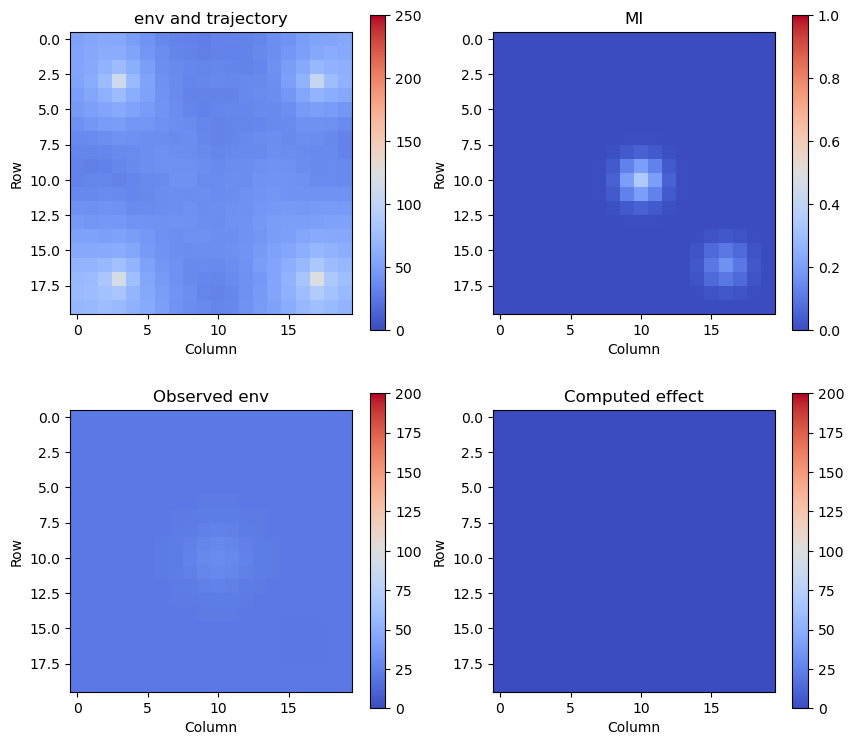

In [15]:
from pypolo2.experiments import visualizer
ani = visualizer.visual(logger)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

In [16]:
import math
import numpy as np
Temp = 1
k = math.pow(0.00002, 1 / 10)
k = math.pow(k, 3)
delta_e_2 = -0.1
accept_prob = np.exp(delta_e_2 / (k * Temp))
print(k)
print(accept_prob)

0.03893220474761734
0.07664525292497093


In [17]:
numbers = rng.randint(0, 19, size=10)
pairs = rng.choice(numbers, size=(5, 2), replace=False)
print(pairs)

[[ 7  3]
 [ 8  6]
 [ 7  8]
 [13 15]
 [ 6 16]]


In [18]:
Setting.RR

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])